In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint

# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import scale as std_scale, robust_scale

# from scipy.signal import find_peaks, find_peaks_cwt, peak_widths

import numpy as np
# from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib.animation as ani

import mlgrad.models as models
import mlgrad.regr as regr
import mlgrad.cls as cls
import mlgrad.plots as plots
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.loss as loss
import mlgrad.gd as gd
import mlgrad.smooth as smooth

import rampy
import pybaselines
import random

from irsa import io
from irsa.preprocess import despike, utils

import copy

# import xarray as xr

import ipywidgets
from IPython.display import display

# %matplotlib widget

In [2]:
attrs = io.collect_attr_values(f"/home/intellimath/repos/spectras")
pprint(attrs)

{'вид_бактерий': ['SA'],
 'время_накопления': ['0.5', '1'],
 'дата': ['20231030', '20240701', '20240704', '20240708', '20240709'],
 'дата_подложки': ['231030', '240301', '240625'],
 'количество_спектров_в_серии': ['15', '30'],
 'комментарий': ['0', '24hr_after_drying'],
 'лазер': ['532'],
 'мощность_лазера': ['4.08'],
 'начальная_концентрация_клеток_в_пробе': ['3', '6'],
 'номер_отбора_из_чашки_петри': ['1'],
 'номер_повтора': ['1', '5'],
 'номер_цикла': ['3'],
 'номер_эксперимента_в_цикле': ['1', '3', '5', '6'],
 'отсечки_по_молекулярной_массе': ['less10', 'less30', 'more30'],
 'резистентность': ['R', 'S'],
 'тип_измерения_спектров': ['SE'],
 'тип_подложки': ['Ag#G_Af'],
 'штамм_бактерий': ['191', '606', '92', '93', '95', '96']}


In [3]:
keys = ['штамм_бактерий', 'резистентность', 'начальная_концентрация_клеток_в_пробе', 
        'отсечки_по_молекулярной_массе', 'номер_эксперимента_в_цикле', 'дата']

selectors = {}
for key in keys:
    vals = attrs[key]
    selectors[key] = ipywidgets.SelectMultiple(options=vals, description=key)
options_button = ipywidgets.Button(description="Select")
output = ipywidgets.Output()

options = {}
def onclick_options_button(b):
    for key,sel in selectors.items():
        if sel.value:
            options[key] = sel.value
    with output:
        print(options)

options_button.on_click(onclick_options_button)

options_widgets = list(selectors.values())+[options_button, output]
display(*options_widgets)

SelectMultiple(description='штамм_бактерий', options=('191', '606', '92', '93', '95', '96'), value=())

SelectMultiple(description='резистентность', options=('R', 'S'), value=())

SelectMultiple(description='начальная_концентрация_клеток_в_пробе', options=('3', '6'), value=())

SelectMultiple(description='отсечки_по_молекулярной_массе', options=('less10', 'less30', 'more30'), value=())

SelectMultiple(description='номер_эксперимента_в_цикле', options=('1', '3', '5', '6'), value=())

SelectMultiple(description='дата', options=('20231030', '20240701', '20240704', '20240708', '20240709'), value…

Button(description='Select', style=ButtonStyle())

Output()

In [11]:
def plot_spectra_series(key, i, zval):
    plt.figure(figsize=(12,5))
    entry = d[key]
    x = entry.x[i]
    ys = entry.y[i]
    plt.title(f"{key} [{len(entry.y)}] [{len(ys)}]")
    for j, y in enumerate(ys):
        plt.plot(x, y, linewidth=0.5, label=str(j), alpha=0.5)
    ys_m = utils.robust_mean2(ys, tau=zval)
    # ys_m_smooth = rampy.whittaker(ys_m, Lambda=1.0e7)
    # max_ys_m = max(ys_m) / 10
    ys_m_smooth = smooth.whittaker_smooth(ys_m, tau=1.0)
    # ys_m_smooth *= max_ys_m
    # print(f"qvals: {qvals}")
    plt.plot(x, ys_m, linewidth=1.5, color='r')
    plt.plot(x, ys_m_smooth, linewidth=1.5, color='k')

    # ys_max = np.mean(ys_m_smooth)
    def arpls_func(E, exp=np.exp):
        E1 = E[E < 0]
        e_m = abs(E1.mean())
        s_m = abs(E1 - e_m).mean()
        EE = (E + e_m + 2*s_m) / s_m
        W = 2/(1 + exp(2*E))
        return W
    # bs, dd2 = smooth.whittaker_weight_func(ys_m_smooth, weight_func=arpls_func, tau=1.0e5, tol=1.0e5)
    bs, _ = pybaselines.whittaker.aspls(ys_m_smooth, x_data=x, lam=1.0e4, diff_order=2)
    # bs *= ys_max
    plt.plot(x, bs, linewidth=2.0, color='m')

    # dys_m = abs(ys - ys_m_smooth) / (ys_m_smooth + 0.001)
    # ds4 = np.nanmedian(abs(ys_m - ys_m_smooth) / (ys_m + 0.001))
    # dy_m = np.nanmedian(dys_m, axis=0)
    # ds = np.nanmedian(dy_m) 
    # ds2 = np.nanpercentile(dy_m, 75)
    
    plt.hlines(0, 0, max(x), colors='k', linestyles='--')
    plt.xlim(-10, max(x)+10)
    # plt.ylim(-10, max(ys[0,42:])+100)
        
    plt.minorticks_on()
    plt.tight_layout()
    # plt.legend([str(i), f"{ds:.2f} / {ds2:.2f} ... {ds4:.4f}", "baseline"])
    plt.show()

    # plt.figure(figsize=(12,4))
    # log_ys_m_smooth = np.log(1+ys_m_smooth)
    # plt.plot(x, log_ys_m_smooth)
    # bs2, _ = pybaselines.whittaker.aspls(log_ys_m_smooth, x_data=x, lam=1.0e5, diff_order=2)
    # plt.plot(x, bs2)
    # plt.minorticks_on()
    # plt.show()
    
    # plt.figure()
    # plt.loglog(dd['qvals'])
    # plt.show()

    # plt.figure()
    # plt.plot(np.log(dd2['qvals']))
    # plt.show()

def plot_zscore_series(key, i, zval):
    plt.figure(figsize=(12,2))
    # plt.title(f"Modified z-score: {key}: {i}")
    entry = d[key]
    x = entry.x[i]
    ys = entry.y[i]
    zs = utils.modified_zscore2(ys)
    abs_zs = abs(zs)
    for z in abs_zs:
        plt.plot(x, z, linewidth=0.5, alpha=0.5)
    plt.plot(x, utils.robust_mean2(abs_zs, tau=zval), linewidth=2.0, color='k')
    plt.hlines(0, 0, max(x), colors='k', linestyles='--')
    plt.hlines(zval, 0, max(x), colors='k', linewidth=1.0)
    plt.xlim(-10, max(x)+10)
        
    plt.minorticks_on()
    plt.tight_layout()
    plt.legend(["Modified z-score"])
    plt.xticks([])
    plt.show()


In [5]:
options = {'резистентность': ('R',), 'отсечки_по_молекулярной_массе': ('less30',)}
d = io.load_spectras(f"/home/intellimath/repos/spectras", options)

file: 3_3_SA_95_R_3_1_less30_1_0
file: 3_3_SA_96_R_3_1_less30_1_0
file: 3_1_SA_96_R_6_1_less30_1_0
file: 3_2_SA_96_R_6_1_less30_1_!24hours after drying!


In [6]:
d_keys = list(d.keys())
sel_i = 0
sel = ipywidgets.Select(options=d_keys,  description="Key:", rows=len(d)+1)
sel.layout.width="50%"

i_slider = ipywidgets.IntSlider(min=0, max=len(d[d_keys[0]].y)-1)
i_slider.layout.width="50%"

f_slider = ipywidgets.FloatSlider(value=3.5, min=1.0, max=10.0)
f_slider.layout.width="50%"

def sel_on_value_change(change):
    i_slider.value = 0
    i_slider.max = len(d[sel.value].y)-1

# def i_on_value_change(change):
#     plot_spectra_series(sel.value, i_slider.value, f_slider.value)

# def f_on_value_change(change):
#     plot_spectra_series(sel.value, i_slider.value, f_slider.value)

sel.on_trait_change(sel_on_value_change, name="value")
# i_slider.on_trait_change(i_on_value_change, name="value")
# f_slider.on_trait_change(f_on_value_change, name="value")

# ipywidgets.VBox([sel, i_slider, out])

In [7]:
for i, key in enumerate(d):
    entry1 = d[key]
    entry1.crop(48)    
    # entry1.use_range(end_index=15)    

In [8]:
for i, key in enumerate(d):
    entry1 = d[key]
    # entry1.smooth(tau=1.0)
    entry1.allign_bottom()


    # entry1.remove_overflow_spectras(y_max=2000.0, y_max_count=30)
    # entry1.remove_outlier_spectras(delta=0.10, tau=3.5)
    # entry1.remove_by_zscore_spectras(tau=3.5, max_count=50)
    # print(len(entry1.y))

In [9]:
@ipywidgets.interact(key=sel, i=i_slider, f=f_slider, zscore=False)
def plot_spectra_zscore(key, i, f, zscore):
    plot_spectra_series(key, i, f)


interactive(children=(Select(description='Key:', layout=Layout(width='50%'), options=('SA_95_R_less30_3_3_1_20…

In [10]:
@ipywidgets.interact(key=sel, i=i_slider, f=f_slider, zscore=False)
def plot_spectra_zscore(key, i, f, zscore):
    # if i > len(d[key].y)-1:
    #     i = 0
    #     i_slider.value=i
    #     i_slider.max = len(d[key].y)-1

    plot_spectra_series(key, i, f)
    if zscore:
        plot_zscore_series(key, i, f)


interactive(children=(Select(description='Key:', layout=Layout(width='50%'), options=('SA_95_R_less30_3_3_1_20…

In [11]:
d2 = {}
for i, key in enumerate(d):
    entry2 = d[key]
    d2[key] = entry2.robust_averaging(tau=2.0)


In [12]:
for i, key in enumerate(d):
    entry3 = d2[key]
    entry3.smooth(methos="irsa", tau=1.)
    entry3.allign_bottom()
    entry3.normalize_area_under_curve()
    entry3.remove_by_zscore_spectras(tau=3.5, max_count=40)
    entry3.subtract_baseline("aspls", lam=1.0e3)
    # entry3.replace_small_values(0.01)
    # entry3.normalize_area_under_curve()
    # print(entry3.x.shape, entry3.y.shape)
    # entry3.y = entry3.remove_outlier_spectras(tau=3.5)
    # Is = [i for i,ys in enumerate(entry3.y) if np.any(np.isnan(ys))]
    # print(Is)            

    # # entry3.subtract_baseline("mor", max_half_window=5, min_half_window=1)


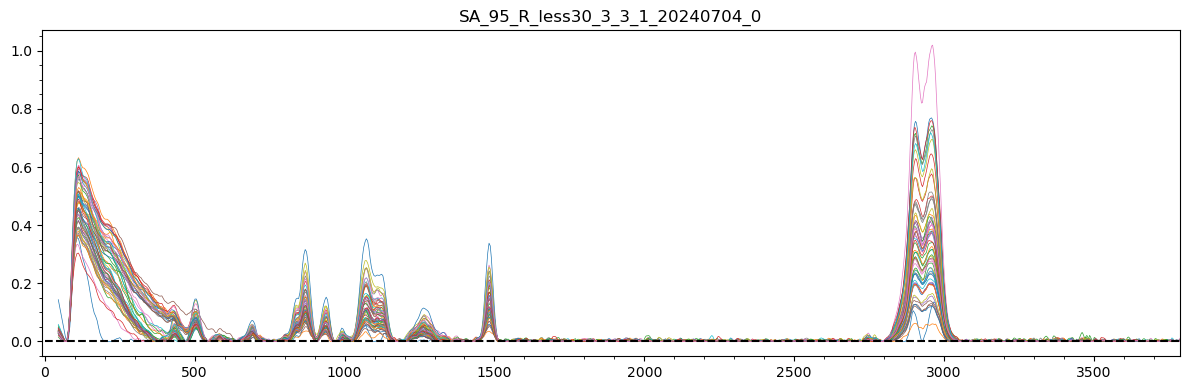

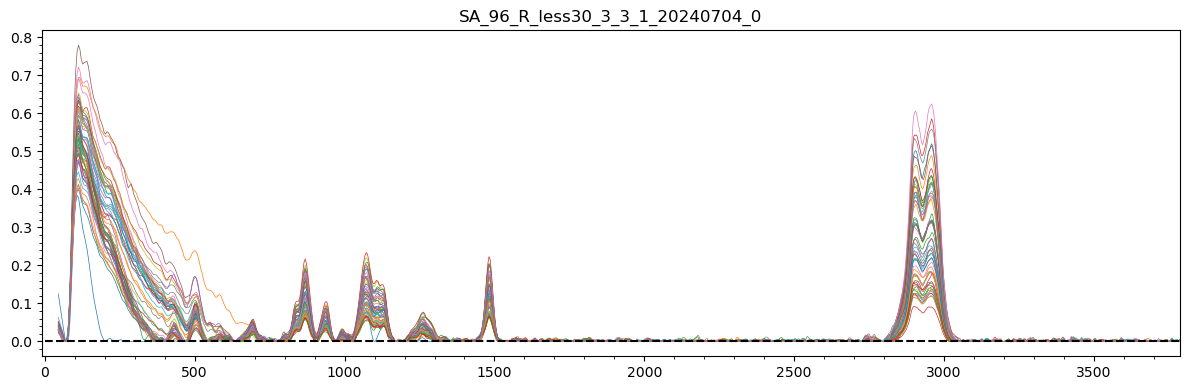

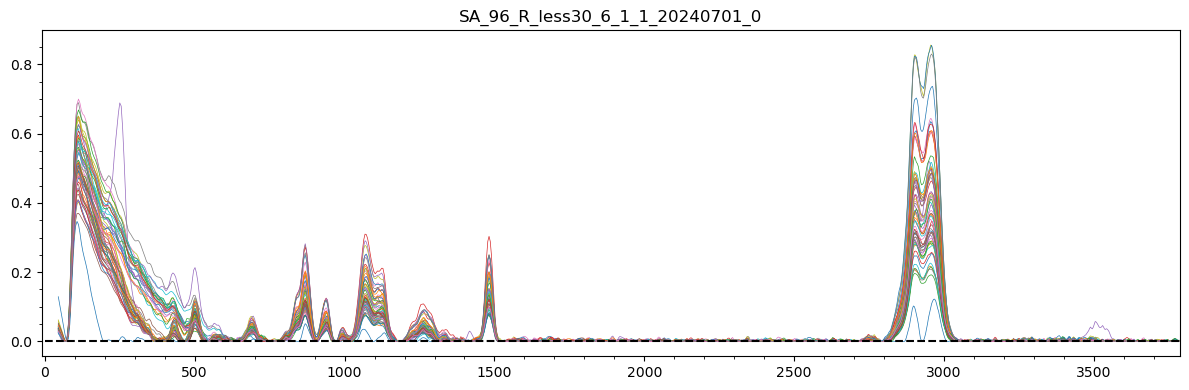

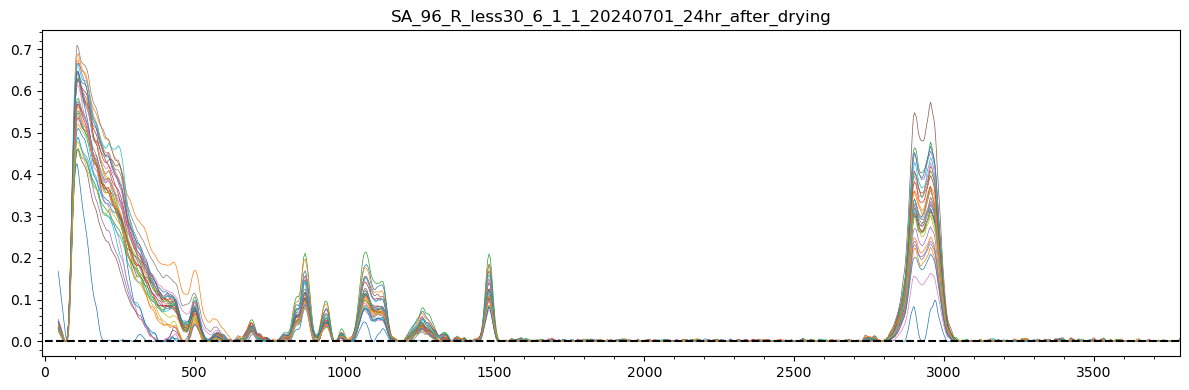

In [13]:
for i, key in enumerate(d):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    plt.figure(figsize=(12,4))
    plt.title(key)
    for xs, ys in zip(Xs, Ys):
        plt.plot(xs, ys, linewidth=0.5)
    plt.hlines(0, 0, max(xs), colors='k', linestyles='--')
    plt.xlim(-10, max(xs))
        
    plt.minorticks_on()
    plt.tight_layout()
    # plt.legend()
    plt.show()
    
    # plt.figure(figsize=(12,3))
    # Zs = utils.modified_zscore2(Ys)
    # for xs,zs in zip(Xs,Zs):
    #     plt.plot(xs,abs(zs), linewidth=0.5, marker='s', markersize=1)
    # plt.hlines(3.5, 0, max(xs), colors='k', linestyle='--')
    # plt.minorticks_on()
    # plt.tight_layout()
    # plt.show()
    

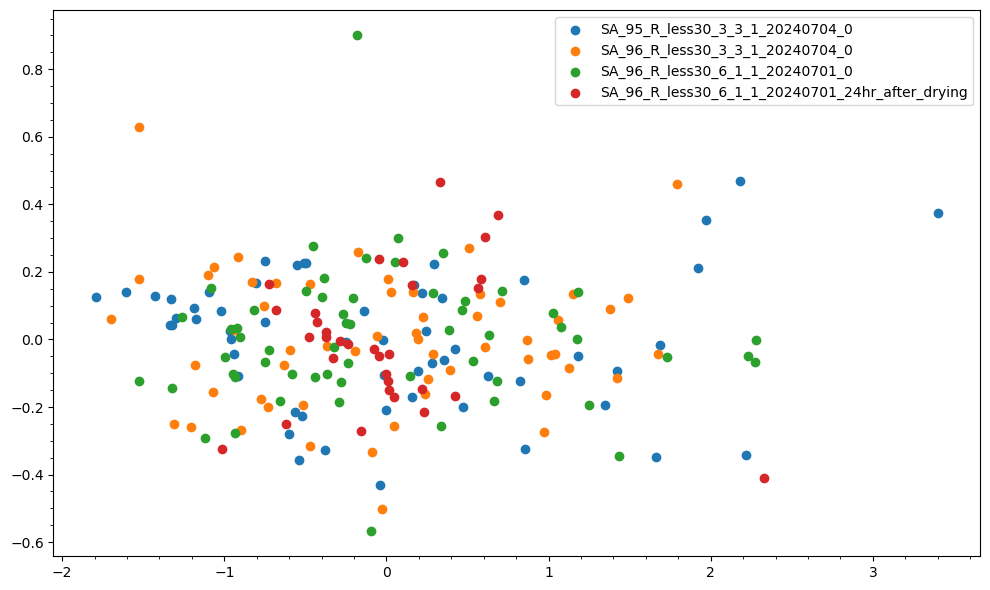

In [14]:
from sklearn.decomposition import PCA
from numpy.linalg import det, inv

plt.figure(figsize=(10,6))
for i, key in enumerate(d):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    pca = PCA(5)
    pca.fit(Ys)
    Us = pca.transform(Ys)

    S = Us.T @ Us
    S /= np.sqrt(det(S))
    S = inv(S)
    # print(S)


    sc = plt.scatter(Us[:,0], Us[:,2], label=key)
    c = sc.get_facecolor()

    # x_min, x_max = min(Us[:,0]), max(Us[:,0])
    # y_min, y_max = min(Us[:,1]), max(Us[:,1])

    # xr = np.linspace(x_min, x_max, 50)
    # yr = np.linspace(y_min, y_max, 50)
    # xx, yy = np.meshgrid(xr, yr)
    # xy = np.c_[xx.ravel(), yy.ravel()]
    # dd = np.sqrt([0.5*((t @ S) @ t) for t in xy])
    # dd = dd.reshape(xx.shape)
    # plt.contour(dd, levels=[4.0], colors=c)
    

plt.minorticks_on()
plt.tight_layout()
plt.legend()
plt.show()

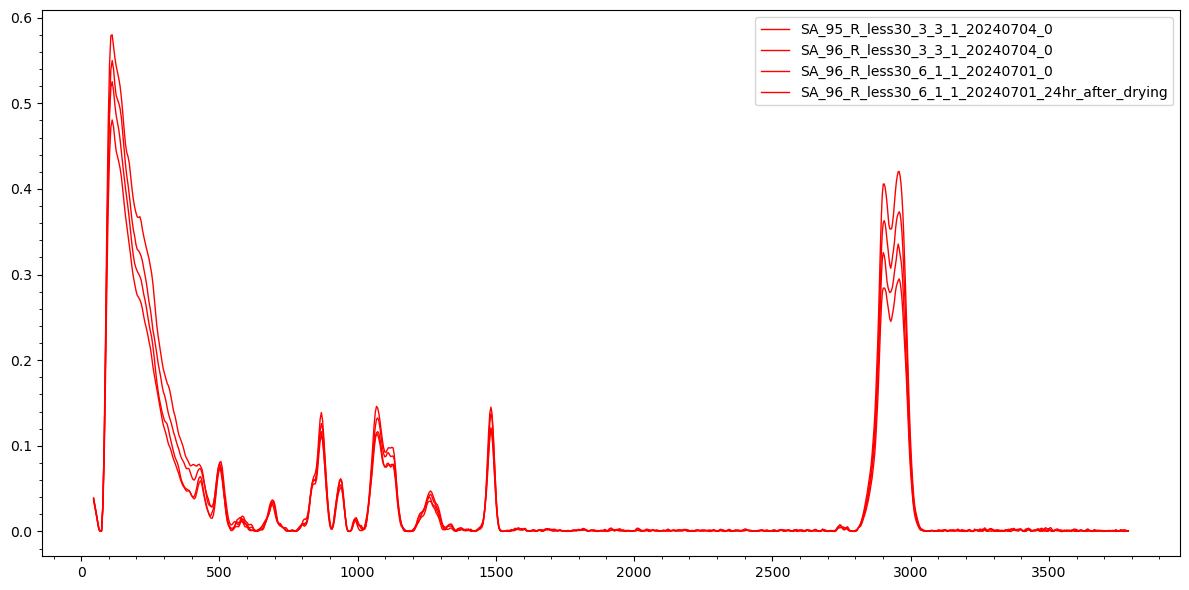

In [15]:
plt.figure(figsize=(12,6))
for i, key in enumerate(d):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    # if "_R_" in key:
    #     if "95" in key:
    #         color='r'
    #     elif "96" in key:
    #         color='Brown'
    # elif "_S_" in key:
    #     if "92" in key:
    #         color='m'
    #     elif "93" in key:
    #         color='b'
    #     else:
    #         color='b'

    if "_R_" in key:
        color='r'
    elif "_S_" in key:
        color='b'
    else:
        color='m'
        
    plt.plot(np.mean(Xs, axis=0), np.mean(Ys, axis=0), linewidth=1.0, color=color, label=key)
    # plt.plot(np.mean(Ys, axis=0), linewidth=1.0, label=key)
    
# plt.hlines(0, 0, len(Ys[0]), colors='k')
# plt.xlim(-10,1000)
        
plt.minorticks_on()
plt.tight_layout()
plt.legend()
plt.show()

In [16]:
D = np.diff(np.eye(10), 2, axis=0, )
print(D)
print(D.T @ D)

[[ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]]
[[ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [-2.  5. -4.  1.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  6. -4.  1.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  6. -4.  1.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  6. -4.  1.  0.  0.  0.]
 [ 0.  0.  0.  1. -4.  6. -4.  1.  0.  0.]
 [ 0.  0.  0.  0.  1. -4.  6. -4.  1.  0.]
 [ 0.  0.  0.  0.  0.  1. -4.  6. -4.  1.]
 [ 0.  0.  0.  0.  0.  0.  1. -4.  5. -2.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]]


In [17]:
import sympy
from sympy import MatrixSymbol, Identity

In [18]:
D = MatrixSymbol('D', 10, 10)

In [19]:
W = sympy.DiagonalMatrix(MatrixSymbol('W', 10, 10))

In [20]:
D = np.diff(np.eye(10), 2)

In [21]:
DD = np.dot(np.dot(W, D), D.T)

In [22]:
from IPython.display import display

In [23]:
print(DD)

[[1.0*W[0, 0] -2.0*W[0, 0] 1.0*W[0, 0] 0 0 0 0 0 0 0]
 [-2.0*W[1, 1] 5.0*W[1, 1] -4.0*W[1, 1] 1.0*W[1, 1] 0 0 0 0 0 0]
 [1.0*W[2, 2] -4.0*W[2, 2] 6.0*W[2, 2] -4.0*W[2, 2] 1.0*W[2, 2] 0 0 0 0 0]
 [0 1.0*W[3, 3] -4.0*W[3, 3] 6.0*W[3, 3] -4.0*W[3, 3] 1.0*W[3, 3] 0 0 0 0]
 [0 0 1.0*W[4, 4] -4.0*W[4, 4] 6.0*W[4, 4] -4.0*W[4, 4] 1.0*W[4, 4] 0 0 0]
 [0 0 0 1.0*W[5, 5] -4.0*W[5, 5] 6.0*W[5, 5] -4.0*W[5, 5] 1.0*W[5, 5] 0 0]
 [0 0 0 0 1.0*W[6, 6] -4.0*W[6, 6] 6.0*W[6, 6] -4.0*W[6, 6] 1.0*W[6, 6] 0]
 [0 0 0 0 0 1.0*W[7, 7] -4.0*W[7, 7] 6.0*W[7, 7] -4.0*W[7, 7] 1.0*W[7, 7]]
 [0 0 0 0 0 0 1.0*W[8, 8] -4.0*W[8, 8] 5.0*W[8, 8] -2.0*W[8, 8]]
 [0 0 0 0 0 0 0 1.0*W[9, 9] -2.0*W[9, 9] 1.0*W[9, 9]]]
